# EECS 498-007/598-005 Assignment 4-1: Pytorch Autograd and NN

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX

# torch.autograd and torch.nn

So far, we used PyTorch to accelarate computation using GPU.
PyTorch also provides several useful packages, which help to design deep neural networks efficiently.

The `torch.autograd` package provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions.

This notebook assumes that you are using **PyTorch version 1.3**.
In some of the previous versions (e.g. before 0.4), Tensors had to be wrapped in `torch.autograd.Variable` objects to enable autograd;
however this class has now been deprecated and merged with `torch.Tensor`.
In addition 1.0 also separates a Tensor's datatype from its device, and uses numpy-style factories for constructing Tensors rather than directly invoking Tensor constructors.
Now, to obtain gradients for a tensor via autograd from arbitrary scalar valued functions, you can simply set `requires_grad=True`.

The `torch.nn` package defines a set of Modules, which you can think of as a neural network layer that has produces output from input and may have some trainable weights.

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here.
If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better.

1. Part I, Preparation: As we always do, we will use CIFAR-10 dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors with autograd.
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define an arbitrary neural network architecture.
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a fully-connected and convolutional network very conveniently.
5. Part V, Residual Network: please implement your own ResNet to get a high accuracy on CIFAR-10.

Here is a table of comparison:

| API             | Flexibility | Convenience |
|-----------------|-------------|-------------|
| Barebone        | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

## Install starter code
We will continue using the utility functions that we've used for previous assignments: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-u5qa8eot
  Running command git clone --filter=blob:none --quiet https://github.com/deepvision-class/starter-code /tmp/pip-req-build-u5qa8eot
  Resolved https://github.com/deepvision-class/starter-code to commit e8d9fe711870a39796a2f8ad95538e57942d756f
  Preparing metadata (setup.py) ... done
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10266 sha256=b082f492248738fdadb9f15566d9114438613aad699e6ac0c1a1fe2bca5474a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-57rw8gcf/wheels/c9/fa/82/64b6c443adccf6982835123e4300fc4420373c553439ff0ad5
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook.

In [2]:
import coutils
from coutils import fix_random_seed

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

100%|██████████| 170498071/170498071 [00:03<00:00, 43442464.32it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


Note that if CUDA is not enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

We will be using `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [4]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda:0


Before we start, we define the flatten function for convenience.

In [5]:
def flatten(x, start_dim=1, end_dim=-1):
  return x.flatten(start_dim=start_dim, end_dim=end_dim)

# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification.
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely, if `x` is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of `x` with respect to the scalar loss at the end.

### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [6]:
def two_layer_fc(x, params):
  """
  A fully-connected neural networks; the architecture is:
  NN is fully connected -> ReLU -> fully connected layer.
  Note that this function only defines the forward pass;
  PyTorch will take care of the backward pass for us.

  The input to the network will be a minibatch of data, of shape
  (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
  and the output layer will produce scores for C classes.

  Inputs:
  - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
    input data.
  - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
    w1 has shape (H, D) and w2 has shape (C, H).

  Returns:
  - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
    the input data x.
  """
  # first we flatten the image
  x = flatten(x)  # shape: [batch_size, C x H x W]

  w1, b1, w2, b2 = params

  # Forward pass: compute predicted y using operations on Tensors. Since w1 and
  # w2 have requires_grad=True, operations involving these Tensors will cause
  # PyTorch to build a computational graph, allowing automatic computation of
  # gradients. Since we are no longer implementing the backward pass by hand we
  # don't need to keep references to intermediate values.
  # Note that F.linear(x, w, b) is equivalent to x.mm(w.t()) + b
  # For ReLU, you can also use `.clamp(min=0)`, equivalent to `F.relu()`
  x = F.relu(F.linear(x, w1, b1))
  x = F.linear(x, w2, b2)
  return x


def two_layer_fc_test():
  hidden_layer_size = 42
  x = torch.zeros((64, 3, 16, 16), dtype=dtype)  # minibatch size 64, feature dimension 3*16*16
  w1 = torch.zeros((hidden_layer_size, 3*16*16), dtype=dtype)
  b1 = torch.zeros((hidden_layer_size,), dtype=dtype)
  w2 = torch.zeros((10, hidden_layer_size), dtype=dtype)
  b2 = torch.zeros((10,), dtype=dtype)
  scores = two_layer_fc(x, [w1, b1, w2, b2])
  print('Output size:', list(scores.size()))  # you should see [64, 10]

two_layer_fc_test()

Output size: [64, 10]


### Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

**HINT**: For convolutions: https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters!

In [7]:
def three_layer_convnet(x, params):
  """
  Performs the forward pass of a three-layer convolutional network with the
  architecture defined above.

  Inputs:
  - x: A PyTorch Tensor of shape (N, C, H, W) giving a minibatch of images
  - params: A list of PyTorch Tensors giving the weights and biases for the
    network; should contain the following:
    - conv_w1: PyTorch Tensor of shape (channel_1, C, KH1, KW1) giving weights
      for the first convolutional layer
    - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
      convolutional layer
    - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
      weights for the second convolutional layer
    - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
      convolutional layer
    - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
      figure out what the shape should be?
    - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
      figure out what the shape should be?

  Returns:
  - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
  """
  conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
  scores = None
  ##############################################################################
  # TODO: Implement the forward pass for the three-layer ConvNet.              #
  # Hint: F.linear, F.conv2d, F.relu, flatten                                  #
  ##############################################################################
  # Replace "pass" statement with your code

  y1 = F.conv2d(x, conv_w1, conv_b1, padding='same') # Could also be calculated using the following equation (W-K+2P)/S+1 to get same as input size
  s1 = F.relu(y1)
  y2 = F.conv2d(s1, conv_w2, conv_b2, padding='same') # Could also be calculated using the following equation (W-K+2P)/S+1 to get same as input size
  s2 = F.relu(y2)
  s2_flat = flatten(s2)
  y3 = F.linear(s2_flat, fc_w, fc_b)
  scores = y3

  ################################################################################
  #                                 END OF YOUR CODE                             #
  ################################################################################
  return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 10).

In [8]:
def three_layer_convnet_test():
  x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

  conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b1 = torch.zeros((6,))  # out_channel
  conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b2 = torch.zeros((9,))  # out_channel

  # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
  fc_w = torch.zeros((10, 9 * 32 * 32))
  fc_b = torch.zeros(10)

  scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
  print('Output size:', list(scores.size()))  # you should see [64, 10]
three_layer_convnet_test()

Output size: [64, 10]


### Barebones PyTorch: Kaiming Initialization
In this part, we are going to use [Kaiming initialization](https://arxiv.org/abs/1502.01852), which you already implemented in Assignment 3.

Fortunately, PyTorch already provides a function, so we will use this:
[torch.nn.init.kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)

By default, `gain = 2`, because this function assumes that ReLU activation follows.
This is true in the linear and convolutional layers in the models you are going to implement, except for the last fully-connected layer:
in principle, we should give `gain = 1` because ReLU is not applied there.
However, as stated in the [original paper](https://arxiv.org/abs/1502.01852), since the factor 1/2 does not matter if it just exists on one layer, we are going to keep using `gain = 2` for simplicity.

For more details on initialization methods provided by PyTorch, see https://pytorch.org/docs/stable/nn.init.html.

In [9]:
fix_random_seed(0)

# create a weight of shape [3 x 5]
print(nn.init.kaiming_normal_(torch.empty(3,5, dtype=dtype, device=device)))
print(nn.init.zeros_(torch.empty(3,5, dtype=dtype, device=device)))

tensor([[-0.5848, -0.2690, -1.6721,  0.0918, -0.0764],
        [-0.3667, -0.3939, -0.2077, -0.6796, -0.2297],
        [-1.0569,  1.4328,  0.1971, -0.1165,  0.8137]], device='cuda:0')
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')


### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [10]:
def check_accuracy_part2(loader, model_fn, params):
  """
  Check the accuracy of a classification model.

  Inputs:
  - loader: A DataLoader for the data split we want to check
  - model_fn: A function that performs the forward pass of the model,
    with the signature scores = model_fn(x, params)
  - params: List of PyTorch Tensors giving parameters of the model

  Returns: Nothing, but prints the accuracy of the model
  """
  split = 'val' if loader.dataset.train else 'test'
  print('Checking accuracy on the %s set' % split)
  num_correct, num_samples = 0, 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model_fn(x, params)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.nn.functional.cross_entropy` to compute the loss; you can [read about it here](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [11]:
def train_part2(model_fn, params, learning_rate):
  """
  Train a model on CIFAR-10.

  Inputs:
  - model_fn: A Python function that performs the forward pass of the model.
    It should have the signature scores = model_fn(x, params) where x is a
    PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
    model weights, and scores is a PyTorch Tensor of shape (N, C) giving
    scores for the elements in x.
  - params: List of PyTorch Tensors giving weights for the model
  - learning_rate: Python scalar giving the learning rate to use for SGD

  Returns: Nothing
  """
  for t, (x, y) in enumerate(loader_train):
    # Move the data to the proper device (GPU or CPU)
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=ltype)

    # Forward pass: compute scores and loss
    scores = model_fn(x, params)
    loss = F.cross_entropy(scores, y)

    # Backward pass: PyTorch figures out which Tensors in the computational
    # graph has requires_grad=True and uses backpropagation to compute the
    # gradient of the loss with respect to these Tensors, and stores the
    # gradients in the .grad attribute of each Tensor.
    loss.backward()

    # Update parameters. We don't want to backpropagate through the
    # parameter updates, so we scope the updates under a torch.no_grad()
    # context manager to prevent a computational graph from being built.
    with torch.no_grad():
      for w in params:
        if w.requires_grad:
          w -= learning_rate * w.grad

          # Manually zero the gradients after running the backward pass
          w.grad.zero_()

    if t % print_every == 0 or t == len(loader_train)-1:
      print('Iteration %d, loss = %.4f' % (t, loss.item()))
      check_accuracy_part2(loader_val, model_fn, params)
      print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`.

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`.

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the second dimension of `w1`.
The first dimension of `w1` is the hidden layer size, which will also be the second dimension of `w2`.

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes.

You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch.

In [12]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2

w1 = nn.init.kaiming_normal_(torch.empty(hidden_layer_size, C*H*W, dtype=dtype, device=device))
w1.requires_grad = True
b1 = nn.init.zeros_(torch.empty(hidden_layer_size, dtype=dtype, device=device))
b1.requires_grad = True
w2 = nn.init.kaiming_normal_(torch.empty(num_classes, hidden_layer_size, dtype=dtype, device=device))
w2.requires_grad = True
b2 = nn.init.zeros_(torch.empty(num_classes, dtype=dtype, device=device))
b2.requires_grad = True

train_part2(two_layer_fc, [w1, b1, w2, b2], learning_rate)

Iteration 0, loss = 3.5134
Checking accuracy on the val set
Got 153 / 1000 correct (15.30%)

Iteration 100, loss = 2.8268
Checking accuracy on the val set
Got 363 / 1000 correct (36.30%)

Iteration 200, loss = 2.1682
Checking accuracy on the val set
Got 396 / 1000 correct (39.60%)

Iteration 300, loss = 1.8402
Checking accuracy on the val set
Got 419 / 1000 correct (41.90%)

Iteration 400, loss = 1.5706
Checking accuracy on the val set
Got 430 / 1000 correct (43.00%)

Iteration 500, loss = 2.1460
Checking accuracy on the val set
Got 414 / 1000 correct (41.40%)

Iteration 600, loss = 1.9112
Checking accuracy on the val set
Got 405 / 1000 correct (40.50%)

Iteration 700, loss = 1.8575
Checking accuracy on the val set
Got 421 / 1000 correct (42.10%)

Iteration 765, loss = 1.5831
Checking accuracy on the val set
Got 398 / 1000 correct (39.80%)



### BareBones PyTorch: Training a ConvNet

In the below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 45% after one epoch.

In [13]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

channel_1 = 32
channel_2 = 16
kernel_size_1 = 5
kernel_size_2 = 3

learning_rate = 3e-3

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

################################################################################
# TODO: Define and initialize the parameters of a three-layer ConvNet          #
#       using nn.init.kaiming_normal_.                                         #
################################################################################
# Replace "pass" statement with your code

conv_w1 = nn.init.kaiming_normal_(torch.empty(channel_1, C, kernel_size_1, kernel_size_1, dtype=dtype, device=device, requires_grad=True))
conv_b1 = nn.init.zeros_(torch.empty(channel_1, dtype=dtype, device=device, requires_grad=True))

conv_w2 = nn.init.kaiming_normal_(torch.empty(channel_2, channel_1, kernel_size_2, kernel_size_2, dtype=dtype, device=device, requires_grad=True))
conv_b2 = nn.init.zeros_(torch.empty(channel_2, dtype=dtype, device=device, requires_grad=True))

fc_w = nn.init.kaiming_normal_(torch.empty(num_classes, channel_2 * H * W, dtype=dtype, device=device, requires_grad=True))
fc_b = nn.init.zeros_(torch.empty(num_classes, dtype=dtype, device=device, requires_grad=True))

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 2.6007
Checking accuracy on the val set
Got 109 / 1000 correct (10.90%)

Iteration 100, loss = 1.9980
Checking accuracy on the val set
Got 349 / 1000 correct (34.90%)

Iteration 200, loss = 1.7887
Checking accuracy on the val set
Got 392 / 1000 correct (39.20%)

Iteration 300, loss = 1.6613
Checking accuracy on the val set
Got 419 / 1000 correct (41.90%)

Iteration 400, loss = 1.5939
Checking accuracy on the val set
Got 449 / 1000 correct (44.90%)

Iteration 500, loss = 1.6624
Checking accuracy on the val set
Got 449 / 1000 correct (44.90%)

Iteration 600, loss = 1.6295
Checking accuracy on the val set
Got 470 / 1000 correct (47.00%)

Iteration 700, loss = 1.7866
Checking accuracy on the val set
Got 483 / 1000 correct (48.30%)

Iteration 765, loss = 1.2409
Checking accuracy on the val set
Got 461 / 1000 correct (46.10%)



# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`.

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`.

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network.
We use `nn.init.kaiming_normal_` to initialize weights using Kaiming initialization, and `nn.init.kaiming_zeros_` to initialize biases.

In [14]:
class TwoLayerFC(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    # assign layer objects to class attributes
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, num_classes)
    # nn.init package contains convenient initialization methods
    # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
    nn.init.kaiming_normal_(self.fc1.weight)
    nn.init.kaiming_normal_(self.fc2.weight)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)

  def forward(self, x):
    # forward always defines connectivity
    x = flatten(x)
    scores = self.fc2(F.relu(self.fc1(x)))
    return scores

def test_TwoLayerFC():
  input_size = 3*16*16
  x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 3*16*16
  model = TwoLayerFC(input_size, 42, 10)
  scores = model(x)
  print('Architecture:')
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_TwoLayerFC()

Architecture:
TwoLayerFC(
  (fc1): Linear(in_features=768, out_features=42, bias=True)
  (fc2): Linear(in_features=42, out_features=10, bias=True)
)
Output size: [64, 10]


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

We assume that the size of the input of this network is `H = W = 32`, and there is no pooing; this information is required when computing the number of input channels in the last fully-connected layer.
You should initialize the weight matrices of the model using Kaiming normal initialization, and zero out the bias vectors.

**HINT**: [torch.nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d), [torch.nn.init.kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_), [torch.nn.init.zeros_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.zeros_)

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [15]:
class ThreeLayerConvNet(nn.Module):
  def __init__(self, in_channel, channel_1, channel_2, num_classes):
    super().__init__()
    ########################################################################
    # TODO: Set up the layers you need for a three-layer ConvNet with the  #
    # architecture defined above.                                          #
    ########################################################################
    # Replace "pass" statement with your code

    H = 32
    K = 32

    self.conv1 = nn.Conv2d(in_channel, channel_1, 5, padding='same')
    nn.init.kaiming_normal_(self.conv1.weight)
    nn.init.zeros_(self.conv1.bias)

    self.conv2 = nn.Conv2d(channel_1, channel_2, 3, padding='same')
    nn.init.kaiming_normal_(self.conv2.weight)
    nn.init.zeros_(self.conv2.bias)

    self.fc = nn.Linear(channel_2 * H * K, num_classes)
    nn.init.kaiming_normal_(self.fc.weight)
    nn.init.zeros_(self.fc.bias)
    print(self.fc.weight.shape)

    ########################################################################
    #                           END OF YOUR CODE                           #
    ########################################################################

  def forward(self, x):
    scores = None
    ########################################################################
    # TODO: Implement the forward function for a 3-layer ConvNet. you      #
    # should use the layers you defined in __init__ and specify the        #
    # connectivity of those layers in forward()                            #
    ########################################################################
    # Replace "pass" statement with your code

    s1 = F.relu(self.conv1(x))
    s2 = F.relu(self.conv2(s1))
    scores = self.fc(flatten(s2))

    ########################################################################
    #                            END OF YOUR CODE                          #
    ########################################################################
    return scores


def test_ThreeLayerConvNet():
  x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
  model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
  scores = model(x)
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([10, 8192])
ThreeLayerConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)
Output size: [64, 10]


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network.

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [16]:
def check_accuracy_part34(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [17]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule

  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update

  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train_part345(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.

  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  for e in range(epochs):

    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`.

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [18]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
weight_decay = 1e-4

model = TwoLayerFC(C*H*W, hidden_layer_size, num_classes)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay)

_ = train_part345(model, optimizer)

Epoch 0, Iteration 0, loss = 3.3988
Checking accuracy on validation set
Got 139 / 1000 correct (13.90)

Epoch 0, Iteration 100, loss = 2.9726
Checking accuracy on validation set
Got 328 / 1000 correct (32.80)

Epoch 0, Iteration 200, loss = 2.1085
Checking accuracy on validation set
Got 336 / 1000 correct (33.60)

Epoch 0, Iteration 300, loss = 2.1708
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Epoch 0, Iteration 400, loss = 1.9798
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)

Epoch 0, Iteration 500, loss = 1.7868
Checking accuracy on validation set
Got 448 / 1000 correct (44.80)

Epoch 0, Iteration 600, loss = 2.0991
Checking accuracy on validation set
Got 473 / 1000 correct (47.30)

Epoch 0, Iteration 700, loss = 1.6747
Checking accuracy on validation set
Got 474 / 1000 correct (47.40)

Epoch 0, Iteration 765, loss = 1.6845
Checking accuracy on validation set
Got 413 / 1000 correct (41.30)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

You should train the model using stochastic gradient descent without momentum, with L2 weight decay of 1e-4.

In [19]:
fix_random_seed(0)

C = 3
num_classes = 10

channel_1 = 32
channel_2 = 16

learning_rate = 3e-3
weight_decay = 1e-4

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer.#
################################################################################
# Replace "pass" statement with your code

model = ThreeLayerConvNet(C, channel_1, channel_2, num_classes)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

################################################################################
#                                 END OF YOUR CODE
################################################################################

_ = train_part345(model, optimizer)

torch.Size([10, 16384])
Epoch 0, Iteration 0, loss = 3.2691
Checking accuracy on validation set
Got 126 / 1000 correct (12.60)

Epoch 0, Iteration 100, loss = 1.9333
Checking accuracy on validation set
Got 318 / 1000 correct (31.80)

Epoch 0, Iteration 200, loss = 1.7349
Checking accuracy on validation set
Got 372 / 1000 correct (37.20)

Epoch 0, Iteration 300, loss = 1.6907
Checking accuracy on validation set
Got 409 / 1000 correct (40.90)

Epoch 0, Iteration 400, loss = 1.4222
Checking accuracy on validation set
Got 415 / 1000 correct (41.50)

Epoch 0, Iteration 500, loss = 1.5769
Checking accuracy on validation set
Got 436 / 1000 correct (43.60)

Epoch 0, Iteration 600, loss = 1.3385
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)

Epoch 0, Iteration 700, loss = 1.5647
Checking accuracy on validation set
Got 458 / 1000 correct (45.80)

Epoch 0, Iteration 765, loss = 1.7753
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)



# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity.

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way?

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

Before we start, We need to wrap `flatten` function in a module in order to stack it in `nn.Sequential`.
As of 1.3.0, PyTorch supports `nn.Flatten`, so this is not required in the latest version.
However, let's use the following `Flatten` class for backward compatibility for now.

In [20]:
class Flatten(nn.Module):
  def forward(self, x):
    return flatten(x)

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.
Here, let's skip weight initialization for simplicity;
with a more advanced optimizer than the naive SGD, the default initialization provided in `torch.nn` is good enough for shallow networks.

Again, you don't need to tune any hyperparameters here, but you should achieve above 40% accuracy after one epoch of training.

In [21]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
momentum = 0.5

# To give a specific name to each module, use OrderedDict.
model = nn.Sequential(OrderedDict([
  ('flatten', Flatten()),
  ('fc1', nn.Linear(C*H*W, hidden_layer_size)),
  ('relu1', nn.ReLU()),
  ('fc2', nn.Linear(hidden_layer_size, num_classes)),
]))

print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay,
                      momentum=momentum, nesterov=True)

_ = train_part345(model, optimizer)

Architecture:
Sequential(
  (flatten): Flatten()
  (fc1): Linear(in_features=3072, out_features=4000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=4000, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.3772
Checking accuracy on validation set
Got 137 / 1000 correct (13.70)

Epoch 0, Iteration 100, loss = 1.7474
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Epoch 0, Iteration 200, loss = 1.7005
Checking accuracy on validation set
Got 409 / 1000 correct (40.90)

Epoch 0, Iteration 300, loss = 1.6142
Checking accuracy on validation set
Got 445 / 1000 correct (44.50)

Epoch 0, Iteration 400, loss = 1.6343
Checking accuracy on validation set
Got 454 / 1000 correct (45.40)

Epoch 0, Iteration 500, loss = 1.5454
Checking accuracy on validation set
Got 460 / 1000 correct (46.00)

Epoch 0, Iteration 600, loss = 1.4838
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)

Epoch 0, Iteration 700, loss = 1.6662
Checking accuracy on valida

### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You don't have to re-initialize your weight matrices and bias vectors.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.5, with L2 weight decay of 1e-4..

Again, you don't need to tune any hyperparameters but you should see accuracy above 50% after one epoch of training.

In [22]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

channel_1 = 32
channel_2 = 16
kernel_size_1 = 5
pad_size_1 = 2
kernel_size_2 = 3
pad_size_2 = 1

learning_rate = 1e-2
momentum = 0.5

model = None
optimizer = None
################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# Replace "pass" statement with your code

model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(C, channel_1, kernel_size_1, padding=pad_size_1)),
    ('relu1', nn.ReLU()),
    ('conv2', nn.Conv2d(channel_1, channel_2, kernel_size_2, padding=pad_size_2)),
    ('relu2', nn.ReLU()),
    ('flatten', Flatten()),
    ('fc', nn.Linear(channel_2 * H * W, num_classes)),
]))

optimizer = optim.SGD(model.parameters(), learning_rate, momentum, nesterov=True)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

_ = train_part345(model, optimizer)

Architecture:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (flatten): Flatten()
  (fc): Linear(in_features=16384, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.2960
Checking accuracy on validation set
Got 136 / 1000 correct (13.60)

Epoch 0, Iteration 100, loss = 1.6670
Checking accuracy on validation set
Got 382 / 1000 correct (38.20)

Epoch 0, Iteration 200, loss = 1.4606
Checking accuracy on validation set
Got 478 / 1000 correct (47.80)

Epoch 0, Iteration 300, loss = 1.7122
Checking accuracy on validation set
Got 481 / 1000 correct (48.10)

Epoch 0, Iteration 400, loss = 1.6096
Checking accuracy on validation set
Got 490 / 1000 correct (49.00)

Epoch 0, Iteration 500, loss = 1.4308
Checking accuracy on validation set
Got 499 / 1000 correct (49.90)

Epoch 0, Iteration 600, loss = 1.5043
Checking accuracy on valid

# Part V. ResNet for CIFAR-10

In this section, you are going to implement [ResNet](https://arxiv.org/abs/1512.03385), one of the state-of-the-art CNN architecture.
Specifically, you are going to implement a variation of ResNet called [PreResNet](https://arxiv.org/abs/1603.05027), which locates activation before each convolutional layer (so called pre-activation).
You are going to first implement a plain building block, residual block, and then bottleneck block for really deep networks.
Finally, you will implement your own ResNet using those blocks.

Throughout this part, we will follow the PyTorch default weight initialization for conciseness.

## Plain block

First, let's implement a plain block without residual connection.
PreResNet has a different order of layers from the previously implemented ones;
BatchNorm and ReLU precedes Conv.
The name of PreResNet comes form this pre-activation architecture.
Here, for downsampling, we don't introduce MaxPool layers explicitly, but use stride 2 in the first Conv layer in the block.

Concretely, a plain block accepts a feature map of shape $C_{in} \times H_{in} \times W_{out}$ and produces a feature map of shape $C_{out} \times H_{out} \times W_{out}$. If the block performs downsampling, then $W_{out}=W_{in}/2$ and $H_{out}=H_{in}/2$; otherwise $H_{out}=H_{in}$ and $W_{out}=W_{in}$. The plain block consists of the following six layers in order:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout` 3x3 filters, zero-padding of 1, and stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout` 3x3 filters, with zero-padding of 1


In [23]:
class PlainBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.net = None
    ############################################################################
    # TODO: Implement plain block.                                             #
    # Hint: Wrap your layers by nn.Sequential() to output a single module.     #
    #       You don't have use OrderedDict.                                    #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the result in self.net.                                            #
    ############################################################################
    # Replace "pass" statement with your code

    stride = 1
    if downsample:
      stride = 2
    self.net = nn.Sequential(
        nn.BatchNorm2d(Cin),
        nn.ReLU(),
        nn.Conv2d(Cin, Cout, 3, stride, 1),
        nn.BatchNorm2d(Cout),
        nn.ReLU(),
        nn.Conv2d(Cout, Cout, 3, padding=1)
    )

    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################

  def forward(self, x):
    return self.net(x)

In [24]:
data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of PlainBlock without downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of PlainBlock with downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of PlainBlock without downsampling has a *correct* dimension!
The output of PlainBlock with downsampling has a *correct* dimension!


## Residual block

Next, let's implement a residual block.
A residual block adds a residual connection to a plain block. Let $\mathcal{F}$ be a plain block; then the residual version  $\mathcal{R}$ of the plain block $\mathcal{F}$ computes:

$\mathcal{R}(x) = \mathcal{F}(x) + x$

However, this implementation will only work if the output from the plain block $\mathcal{F}(x)$ has the same shape as the input $x$. Based on the plain block that we implemented above, there are two cases where the output of the plain block can have a different shape than the input:

1. The number of output channels $C_{out}$ is different from the number of input channels $C_{in}$
2. The plain block $\mathcal{F}$ performs spatial downsampling

To deal with these cases, we need generalize our definition of the residual block and add a *shortcut connection* $\mathcal{G}$:

$\mathcal{R}(x) = \mathcal{F}(x) + \mathcal{G}(x)$

There are three cases for the shortcut connection $\mathcal{G}$:

1. If $C_{in}=C_{out}$ and $\mathcal{F}$ does not perform downsampling, then $\mathcal{F}(x)$ will have the same shape as $x$, so $\mathcal{G}$ is the identity function: $\mathcal{G}(x) = x$
2. If $C_{in} \neq C_{out}$ and $\mathcal{F}$ does not downsample, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 1.
3. If $\mathcal{F}$ downsamples, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 2.

In the code below, implement a residual block using the plain block we just defined:

In [25]:
from re import X
class ResidualBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.block = None # F
    self.shortcut = None # G
    ############################################################################
    # TODO: Implement residual block using plain block. Hint: nn.Identity()    #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the main block in self.block and the shortcut in self.shortcut.    #
    ############################################################################
    # Replace "pass" statement with your code

    self.block = PlainBlock(Cin, Cout, downsample)

    stride = 1
    if downsample:
      stride = 2

    self.shortcut = nn.Sequential(
        nn.Conv2d(Cin, Cout, 1, stride)
    )

    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################

  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [26]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


## Residual stage

So far, you implemented micro layers, which consists of several convolutional laters.
To efficiently build a deep neural network, we define a macro layer by repeating the micro layers.

For your convenience, we provide the implementation below.

In [27]:
class ResNetStage(nn.Module):
  def __init__(self, Cin, Cout, num_blocks, downsample=True,
               block=ResidualBlock):
    super().__init__()
    blocks = [block(Cin, Cout, downsample)]
    for _ in range(num_blocks - 1):
      blocks.append(block(Cout, Cout))
    self.net = nn.Sequential(*blocks)

  def forward(self, x):
    return self.net(x)

In [28]:
print('Plain block stage:')
print(ResNetStage(3, 4, 2, block=PlainBlock))
print('Residual block stage:')
print(ResNetStage(3, 4, 2, block=ResidualBlock))

Plain block stage:
ResNetStage(
  (net): Sequential(
    (0): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)
Residual block stage:
ResNetStage(
  (net): Sequential(
    (0): 

## Residual stem

A "stem" layer is required at the beginning of the network, which increases the number of channels while keeping the other dimensions.

For your convenience, we provide the implementation below.

In [29]:
class ResNetStem(nn.Module):
  def __init__(self, Cin=3, Cout=8):
    super().__init__()
    layers = [
        nn.Conv2d(Cin, Cout, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self, x):
    return self.net(x)

In [30]:
data = torch.zeros(2, 3, 5, 6)
model = ResNetStem(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!


## ResNet class

Now, it is time to design the ResNet class using the blocks you implemented above!

For general applicability, the class will get a dictionary of the architecture specification as an input, and parse it to build a CNN.

Here we provide a couple of examples of specification;
`networks` is a collection of pre-defined network specifications, where each can be called by `get_resnet(key)`, where key is the name of the network, e.g., `get_resnet('resnet32')` will return a ResNet with 32 layers.

Each specification consists of multiple tuples which correspond to a macro block (`ResNetStage`), and the values in each tuple implies `(num_in_channels, num_out_channels, num_blocks, do_downsample)`.

To avoid dependency on the size of the input, ResNet has an average pooling at the end of the convolutional part, such that the size of the input tensor to the linear layer is always `(batch_size, stage_args[-1][1])`.
You may want to add an average pooling layer (`nn.AvgPool2d`), but it requires to know the size of the input.
Can you relax this requirement?

**Hint**: You can perform average pooling in `forward`.

In [31]:
# example of specifications
networks = {
  'plain32': {
    'block': PlainBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
  'resnet32': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
}

In [32]:
class ResNet(nn.Module):
  def __init__(self, stage_args, Cin=3, block=ResidualBlock, num_classes=10):
    super().__init__()

    self.cnn = None
    ############################################################################
    # TODO: Implement the convolutional part of ResNet using ResNetStem,       #
    #       ResNetStage, and wrap the modules by nn.Sequential.                #
    # Store the model in self.cnn.                                             #
    ############################################################################
    # Replace "pass" statement with your code

    print(stage_args)
    print(block)

    layers = []

    for i in range(len(stage_args)):
      n_cin, n_cout, n_blocks, downsample = stage_args[i]

      if i == 0:
        layers.append(ResNetStem(Cin, n_cin))

      layers += [block(n_cin, n_cin, downsample) for x in range(n_blocks-1)]
      layers.append(block(n_cin, n_cout, downsample))

    layers.append(Flatten())
    self.cnn = nn.Sequential(*layers)

    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
    self.fc = nn.Linear(stage_args[-1][1], num_classes)

  def forward(self, x):
    scores = None
    ############################################################################
    # TODO: Implement the forward function of ResNet.                          #
    # Store the output in `scores`.                                            #
    ############################################################################
    # Replace "pass" statement with your code


    y = self.cnn(x)

    scale = y.shape[1] / self.fc.weight.shape[1]
    if scale > 1:
      pool = nn.AvgPool2d(scale, 1)
      y = pool(y)

    scores = self.fc(y)

    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
    return scores

def get_resnet(name):
  return ResNet(**networks[name])

## Train your model!

Now let's train a few epochs of plain and residual networks with 32 layers on CIFAR.
You will see that deep non-residual networks don't converge well.

**Caution: This takes a long time!**

**Disclaimer: The performance of PreResNet-32 you will see here (~ 80%) would be lower than the best performance this model can achieve, because the convergence requires much more training.**

In [33]:
# def init_module(model):
#   for m in model.modules():
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#       nn.init.kaiming_normal_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)
#     elif isinstance(m, nn.BatchNorm2d):
#       nn.init.ones_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)

names = ['plain32', 'resnet32']
acc_history_dict = {}
iter_history_dict = {}
for name in names:
  fix_random_seed(0)
  print(name, '\n')
  model = get_resnet(name)
#   init_module(model)

  optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4)

  acc_history, iter_history = train_part345(model, optimizer, epochs=10, schedule=[6, 8], verbose=False)
  acc_history_dict[name] = acc_history
  iter_history_dict[name] = iter_history

plain32 

[(8, 8, 5, False), (8, 16, 5, True), (16, 32, 5, True)]
<class '__main__.PlainBlock'>
Epoch 0, Iteration 765, loss = 2.0598
Checking accuracy on validation set
Got 249 / 1000 correct (24.90)

Epoch 1, Iteration 1531, loss = 1.8368
Checking accuracy on validation set
Got 298 / 1000 correct (29.80)

Epoch 2, Iteration 2297, loss = 1.6995
Checking accuracy on validation set
Got 329 / 1000 correct (32.90)

Epoch 3, Iteration 3063, loss = 1.5944
Checking accuracy on validation set
Got 384 / 1000 correct (38.40)

Epoch 4, Iteration 3829, loss = 1.6355
Checking accuracy on validation set
Got 376 / 1000 correct (37.60)

Epoch 5, Iteration 4595, loss = 1.5871
Checking accuracy on validation set
Got 434 / 1000 correct (43.40)

lr decay from 0.01 to 0.001
Epoch 6, Iteration 5361, loss = 1.1569
Checking accuracy on validation set
Got 450 / 1000 correct (45.00)

Epoch 7, Iteration 6127, loss = 1.5482
Checking accuracy on validation set
Got 463 / 1000 correct (46.30)

lr decay from 0.001 t

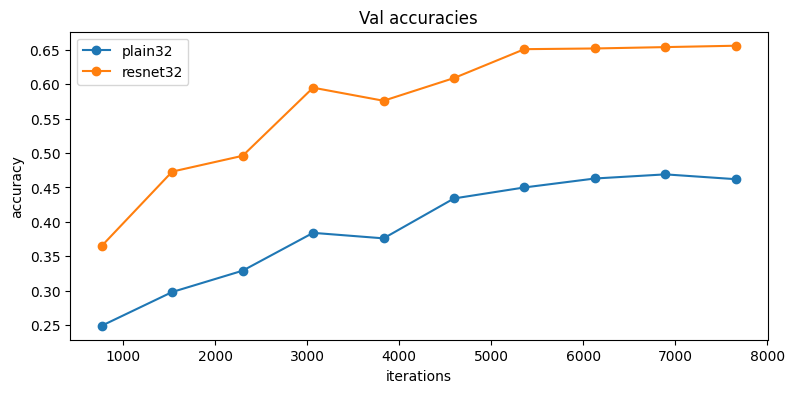

In [34]:
plt.title('Val accuracies')
for name in names:
  plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Residual bottleneck block

A bottleneck block is often useful for better efficiency, especially when importing a model to mobile devices.
The residual bottleneck block is similar to the standard residual block, but the plain block part has a different architecture:
it consists of 3 convolutional layers, and the first two convolutional layers have a smaller number of channels.

Here is the specification of the bottleneck block:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout // 4` 1x1 filters, stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout // 4` 3x3 filters, with zero-padding of 1
7. Spatial Batch normalization
8. ReLU
9. Convolutional layer with `Cout` 1x1 filters

Don't forget to add the residual connection!

In [59]:
class ResidualBottleneckBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.block = None
    self.shortcut = None
    ############################################################################
    # TODO: Implement residual bottleneck block.                               #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the main block in self.block and the shortcut in self.shortcut.    #
    ############################################################################
    # Replace "pass" statement with your code

    quarter_cout = Cout // 4
    stride = 1
    if downsample:
      stride = 2

    self.block = nn.Sequential(
        nn.BatchNorm2d(Cin),
        nn.ReLU(),
        nn.Conv2d(Cin, quarter_cout, kernel_size=1, stride=stride),
        nn.BatchNorm2d(quarter_cout),
        nn.ReLU(),
        nn.Conv2d(quarter_cout, quarter_cout, kernel_size=3, padding=1),
        nn.BatchNorm2d(quarter_cout),
        nn.ReLU(),
        nn.Conv2d(quarter_cout, Cout, 1)
    )

    self.shortcut = nn.Sequential(
        nn.Conv2d(Cin, Cout, 1, stride)
    )

    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################

  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [60]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


By running the following script, you can check the architecture of ResNet-47 with bottlenecks.

Caution: it is long!

In [61]:
# example of specification
networks.update({
  'resnet47': {
    'block': ResidualBottleneckBlock,
    'stage_args': [
      (32, 32, 5, False),
      (32, 64, 5, True),
      (64, 128, 5, True),
    ],
  },
})

print(get_resnet('resnet47'))

[(32, 32, 5, False), (32, 64, 5, True), (64, 128, 5, True)]
<class '__main__.ResidualBottleneckBlock'>
ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResidualBottleneckBlock(
      (block): Sequential(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): ReLU()
        (8): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (shortcut): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
  